In [1]:
# 1 FILTER DATAFRAME USING THE SAME BOUNDING BOX YOU HAVE USED FOR QUERYING THE API
# 2 FETCH THE IMAGE IDS IN THE SAME BOUNDING BOX WITH MAPILLARY
# 3 MATCH THE IMAGE IDS WITH THE EDGE IDS:
#### - ADD EXTRA POINTS BETWEEN EVERY EDGE START AND END (edge points) 
#### - Construct A BALL TREE WITH THE EDGE POINTS (https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers)
#### - Query the Ball tree using the image points (for each image, find the closest point)
#### - Remove matches such that the distance is larger than 50 meters
#### - Build a dictionary image_id --> edge_id

In [2]:
import geopandas as gpd
import matplotlib.pylab as plt
from shapely.geometry import Polygon
import numpy as np
import itertools
from operator import itemgetter
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import requests as rq
import json
from sklearn.neighbors import BallTree

In [3]:
#Load shapefile

my_shapefile_path = "/Users/lauale/Downloads/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
my_shp = gpd.read_file(my_shapefile_path)
#print(my_shp)

In [4]:
#Access to Mapillary API
id = 6271859919532158
clienttoken = 
clientsecret = 

#URL for getting only images within the chosen boundaries
url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox=12.539467,55.660144,12.563714,55.675971"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]


#Loop to get list of coordinates and ID's 
#Not all images has coordinates so the try/except only gets the ID's which has coordinates
coor = []
ID = []
for i in range(0,len(images)):
    try:
        coord = images[i]["computed_geometry"]["coordinates"]
        coor.append(coord)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
#print(coor[0][0])
#print(ID)
new_coor =[] 
for i in range(0,len(coor)):
    vupti = coor[i][0]




#Get coordinates as Shapely Points 
points = []

for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

#print(points)

#Check if Id and points are the same length
#print(len(ID))
#print(len(points))


#Create geopandas dataframe from ID's and points
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
print(df_points)



                    ID                   geometry
0     1801450926853213  POINT (12.55737 55.66037)
1     2911501712440290  POINT (12.54308 55.66539)
2     1235659653857863  POINT (12.55091 55.67440)
3     1470218986659594  POINT (12.55588 55.66788)
4     1705111989695458  POINT (12.55080 55.66308)
...                ...                        ...
1981  4172973032761225  POINT (12.54227 55.67235)
1982  4407818742614485  POINT (12.54001 55.66507)
1983  2962162034064159  POINT (12.55036 55.66519)
1984  2988793198070343  POINT (12.54236 55.66420)
1985  4146091738785144  POINT (12.55158 55.66653)

[1986 rows x 2 columns]


In [29]:
#Set boundaries
bound = Polygon([(12.539467, 55.660144), (12.539467, 55.675971),(12.563714, 55.675971), (12.563714, 55.660144)])

#Find the values from the shapefile that is within the boundaries
TF = my_shp.within(bound)


edges_within_bound_index = TF[TF].index

geo_tag = my_shp["geometry"][TF.values]


emp_list = []
for i in range(0,len(edges_within_bound_index)):
    segment_list = []
    for i in list(geo_tag.iloc[i].coords):
        segment_list.append(list(i))
    #if 2 < len(segment_list):
    #    continue
    emp_list.append(segment_list)



#Create dataframe 
data1 = {"ID": my_shp["edgeUID"][TF.values], "geometry": geo_tag}
df_lines = gpd.GeoDataFrame(data1)
"""

df_lines = gpd.GeoDataFrame(TF)
#print(df_lines)
"""



'\n\ndf_lines = gpd.GeoDataFrame(TF)\n#print(df_lines)\n'

<AxesSubplot: >

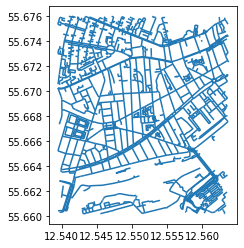

In [30]:
df_lines["geometry"].plot()

/var/folders/63/4p166hs50g3b807b74p8j46h0000gp/T/ipykernel_41398/344356141.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0005).plot(ax=ax,alpha=0.5)


<AxesSubplot: >

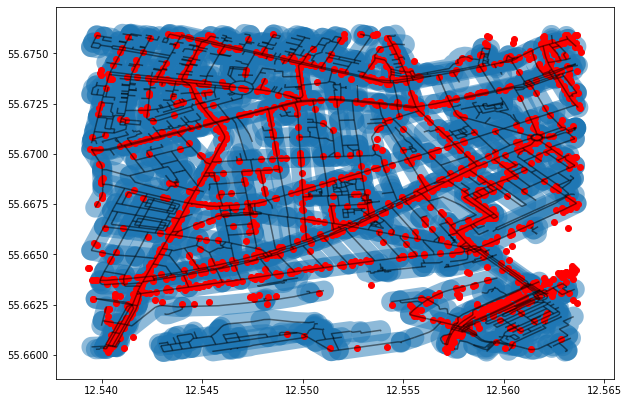

In [40]:
fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0005).plot(ax=ax,alpha=0.5)
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
df_points["geometry"].plot(ax=ax,color = "r")

In [60]:
df_polygons = df_lines.copy()
df_polygons.crs = df_lines.crs
df_points.crs = df_lines.crs
df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001)

pointInPoly = gpd.sjoin(df_points, df_polygons, how='left',predicate='within') 

/var/folders/63/4p166hs50g3b807b74p8j46h0000gp/T/ipykernel_41398/3933553022.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001)


In [61]:
pointInPoly

,ID_left,geometry,index_right,ID_right
0,1801450926853213,POINT (12.55737 55.66037),NaN,NaN
1,2911501712440290,POINT (12.54308 55.66539),184849.0,174472869.0
2,1235659653857863,POINT (12.55091 55.67440),90912.0,174476330.0
2,1235659653857863,POINT (12.55091 55.67440),116728.0,174476376.0
2,1235659653857863,POINT (12.55091 55.67440),183557.0,174476329.0
...,...,...,...,...
1984,2988793198070343,POINT (12.54236 55.66420),132437.0,174472807.0
1985,4146091738785144,POINT (12.55158 55.66653),11433.0,174475025.0
1985,4146091738785144,POINT (12.55158 55.66653),33640.0,174475027.0
1985,4146091738785144,POINT (12.55158 55.66653),76712.0,174475079.0


<AxesSubplot: >

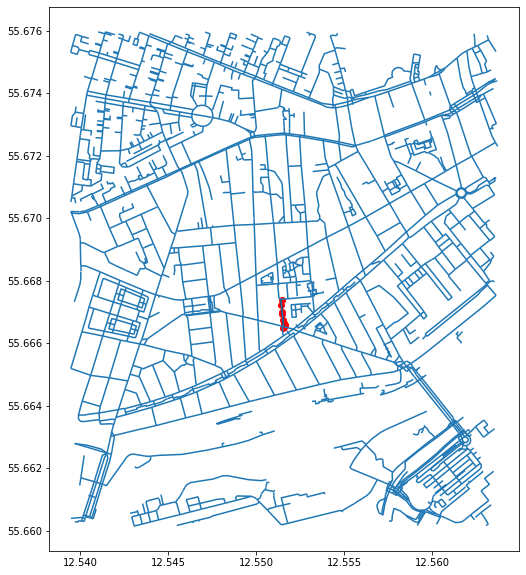

In [62]:
fig, ax = plt.subplots(figsize = (10,10))
test = pointInPoly[pointInPoly.ID_right==174475028].copy()
df_lines[df_lines.ID==174475028].plot(ax=ax, color = "k")
df_lines.plot(ax=ax)
test["geometry"].plot(color = "r",ax=ax)

In [15]:
#https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas

def ckdnearest(gdfA, gdfB, gdfB_cols=['ID']):
    # resetting the index of gdfA and gdfB here.
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='distance')], axis=1)
    return gdf

c = ckdnearest(df_points, df_lines)
print(c)

                    ID                   geometry         ID  distance
0     1235659653857863  POINT (12.55091 55.67440)  174475929  0.005099
1     1705111989695458  POINT (12.55080 55.66308)  174475022  0.004090
2     2854086148239864  POINT (12.55062 55.67220)  174475929  0.003070
3     2875560682717577  POINT (12.54881 55.66494)  174474964  0.001661
4     2902922359988409  POINT (12.54158 55.66086)  174472591  0.000658
...                ...                        ...        ...       ...
1980  1684506568553582  POINT (12.55861 55.66800)  174476776  0.000119
1981  2881440428737867  POINT (12.55097 55.67426)  174475929  0.005009
1982  4284692578209138  POINT (12.55038 55.67443)  174475929  0.004929
1983  1801919433522660  POINT (12.56098 55.66277)  174475573  0.000332
1984  1409000056578764  POINT (12.55794 55.66102)  174475557  0.002566

[1985 rows x 4 columns]


In [63]:
# https://autogis-site.readthedocs.io/en/2019/notebooks/L3/nearest-neighbor-faster.html

In [17]:
from math import radians
earth_radius = 6371000 # meters in earth

ind = []
results = []

for i in range(0,len(emp_list)):
    test_points = emp_list[i]
    test_points_rad = np.array([[radians(x[0]), radians(x[1])] for x in test_points ])
    train_points = coor[i]
    train_points_rad = np.array([[radians(x)] for x in train_points ])
    tree = BallTree(test_points_rad, metric = 'haversine')
    ind,results = tree.query(train_points_rad, k=1)
    ind.append(ind)
    results.append(results * earth_radius/1000)



ValueError: query data dimension must match training data dimension

(55.660144, 55.675971)

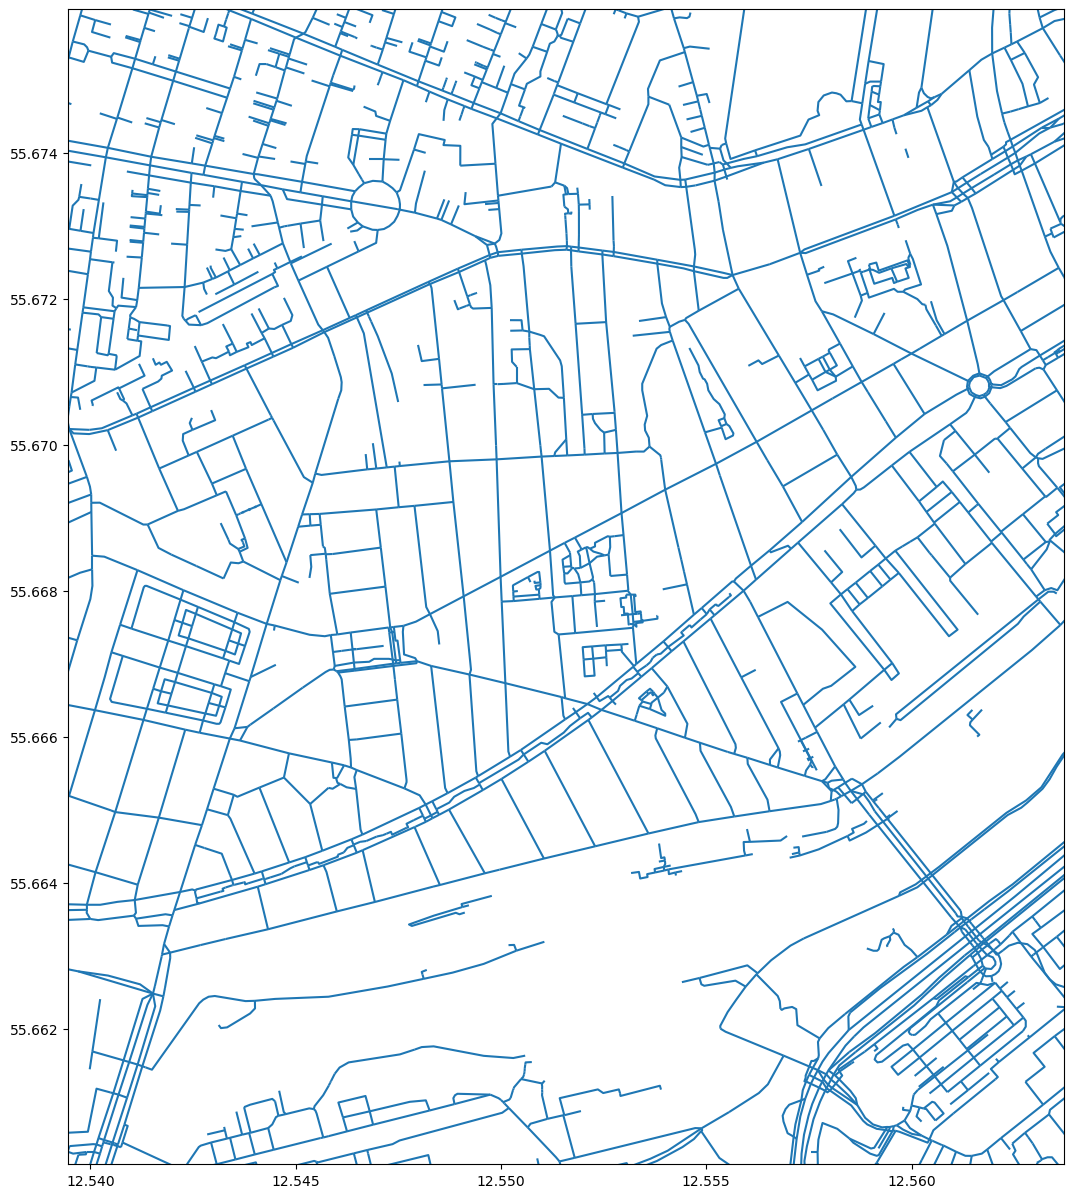

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
my_shp.plot(ax = ax)

ax.set_xlim(12.539467, 12.563714)
ax.set_ylim(55.660144, 55.675971)